# INFO 2950 Phase 2
##### Janice Shen (js3678), Khai Xin Kuan (kk996), Sandy Lin (sl2534), David Park (yp358)

### Research Question
Can we predict the valence (a spectrum indicating negative or positive emotions, with 0 indicating most negative and 1 indicating most positive) of the general population’s music preference based on the interest rate, unemployment rate, inflation, and other economic variables?

Can we predict the danceability (with 0.0 being the least danceable and 1.0 being the most danceable) of the general population’s music preference based on the interest rate, unemployment rate, inflation, and other economic variables?



Resources use:
two y variable on one lineplot: https://stackoverflow.com/questions/55654500/seaborn-plot-with-second-y-axis

In [1]:
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression

In [ ]:
# importing billboard and spotify csv files
billboard_df = pd.read_csv('billboard.csv')
spotify_df = pd.read_csv('spotify.csv')

In [ ]:
# looking at columns
billboard_df.head()

,index,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,0,http://www.billboard.com/charts/hot-100/1965-0...,7/17/1965,34,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,45.0,34,4
1,1,http://www.billboard.com/charts/hot-100/1965-0...,7/24/1965,22,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,34.0,22,5
2,2,http://www.billboard.com/charts/hot-100/1965-0...,7/31/1965,14,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,22.0,14,6
3,3,http://www.billboard.com/charts/hot-100/1965-0...,8/7/1965,10,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,14.0,10,7
4,4,http://www.billboard.com/charts/hot-100/1965-0...,8/14/1965,8,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,10.0,8,8


In [ ]:
spotify_df.head()

,index,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,spotify_track_album,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity
0,0,-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,¿Dònde Està Santa Claus? (Where Is Santa Claus...,Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus?),['novelty'],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,The Essential Andy Williams,...,-14.063,1.0,0.0315,0.91100,0.000267,0.112,0.150,83.969,4.0,38.0
3,3,...And Then There Were DrumsSandy Nelson,Sandy Nelson,...And Then There Were Drums,"['rock-and-roll', 'space age pop', 'surf music']",1fHHq3qHU8wpRKHzhojZ4a,NaN,172066.0,False,Compelling Percussion,...,-17.278,0.0,0.0361,0.00256,0.745000,0.145,0.801,121.962,4.0,11.0
4,4,...Baby One More TimeBritney Spears,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3MjUtNVVq3C8Fn0MP3zhXa,https://p.scdn.co/mp3-preview/da2134a161f1cb34...,211066.0,False,...Baby One More Time (Digital Deluxe Version),...,-5.745,0.0,0.0307,0.20200,0.000131,0.443,0.907,92.960,4.0,77.0


In [ ]:
# Convert weekID in billboard_df to datetime and extract the month and year
billboard_df['WeekID'] = pd.to_datetime(billboard_df['WeekID'])
billboard_df['Year-Month'] = billboard_df['WeekID'].dt.to_period('M')

In [ ]:
# extract relevant columns
billboard_cleaned = billboard_df[['Song', 'Performer', 'Year-Month']]
# columns for spotify dataset that we can use for EDA later
spotify_cleaned = spotify_df[['Song', 'Performer', 'valence', 
                             'danceability', 'spotify_genre', 'tempo']]

# one concern is that there might be duplicate songs in the charts
# but we could explain that there is no concern, because we're analyzing the
# listening pattern and tracking valence of those listeners.

In [ ]:
# standardizing song and artist name for merging
billboard_cleaned['Song'] = billboard_cleaned['Song'].str.lower().str.strip()
billboard_cleaned['Performer'] = billboard_cleaned['Performer'].str.lower().str.strip()
spotify_cleaned['Song'] = spotify_cleaned['Song'].str.lower().str.strip()
spotify_cleaned['Performer'] = spotify_cleaned['Performer'].str.lower().str.strip()

/var/folders/kz/g2rg6w5n7px66q8chk6_hpjm0000gn/T/ipykernel_91667/653683805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billboard_cleaned['Song'] = billboard_cleaned['Song'].str.lower().str.strip()
/var/folders/kz/g2rg6w5n7px66q8chk6_hpjm0000gn/T/ipykernel_91667/653683805.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billboard_cleaned['Performer'] = billboard_cleaned['Performer'].str.lower().str.strip()
/var/folders/kz/g2rg6w5n7px66q8chk6_hpjm0000gn/T/ipykernel_91667/653683805.py:4: SettingWith

In [ ]:
# merging dataframe
merged_df_music = pd.merge(billboard_cleaned, spotify_cleaned, \
    on=['Song', 'Performer'], how='inner')

In [ ]:
# getting unemployment data
unemployment_df = pd.read_csv('un.csv')
unemployment_df.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [ ]:
unemployment_df['DATE'] = pd.to_datetime(unemployment_df['DATE'])
unemployment_df['Year-Month'] = unemployment_df['DATE'].dt.to_period('M')

In [ ]:
unemployment_cleaned = unemployment_df[['Year-Month', 'UNRATE']]

### Data Descriptions
We collected 4 sets of data to analyze. We downloaded scraped spotify data from calebelgut’s github. The data contains an abundant of information about all the songs released from the years 1921-2020, including danceability, valence, popularity, and energy, for which we attempted to use as a measure of the general population’s music sentiment over the years. We had another music dataset of the 10,000 most popular Spotify songs from the years 1050-now. We then downloaded a dataset that corresponds with the monthly interest rate from the years 1948-2024, which we used to get the average interest rate over a certain year period. We then downloaded another set of data that included information about the other economic variables, such as the unemployment rate, inflation rate, and real GDP change.

In [2]:
musicdata = pd.read_csv("data.csv")
type(musicdata)

pandas.core.frame.DataFrame

In [3]:
econdata= pd.read_csv("index.csv")

In [4]:
songdata=pd.read_csv("top10000song.csv")

In [5]:
interestdata= pd.read_csv("interest.csv")

### Data Collection and Cleaning
Initially we used the spotify data set from, checked to see there was any NaN values which there wasn’t any so we went ahead and made a clean table with only the variables of interest. We then merged data variables into a consolidated table. This time, the unemployment rate data had NaN which we had to drop. 


For the spotify data set, we looked into the shape to see if it has enough data through the shape function, and we checked for Nan, which there weren’t any so it is clean.

In [6]:
musicdata.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [9]:
# checking to see NaN values
print("Number of music danceability: ", len(musicdata['danceability']))
print("Nan is present: ",\
      np.isnan(musicdata['danceability']).any())

Number of music danceability:  169909
Nan is present:  False


We merged Econ  data sets into a consolidated table. 

In [10]:
econdata.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


We only took the variables of interest in the spotify dataset: danceability, year, valence.

In [11]:
cleandata= musicdata[["danceability","year", "valence"]]

In [12]:
corr = cleandata.corr()
print(corr)

              danceability      year   valence
danceability      1.000000  0.203430  0.560242
year              0.203430  1.000000 -0.029304
valence           0.560242 -0.029304  1.000000


We wanted to see the behavior of danceability and valence for possible better fitting. 

<Axes: xlabel='year', ylabel='valence'>

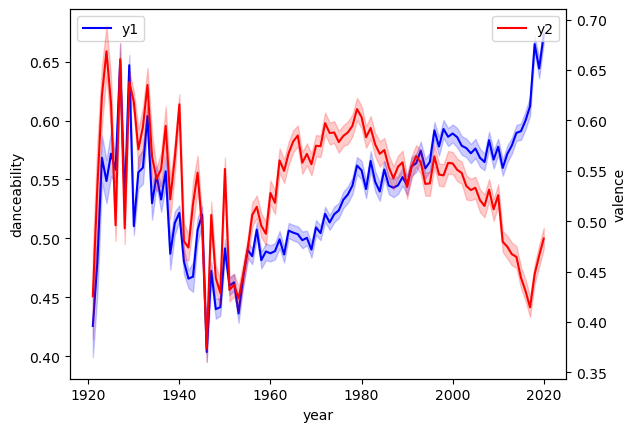

In [16]:
fig, ax1 = plt.subplots()
sns.lineplot(x='year', y='danceability', data=cleandata, ax=ax1, color='blue', label='danceability')
ax2 = ax1.twinx()
sns.lineplot(x='year', y='valence', data=cleandata, ax=ax2, color='red', label='valence')

In [12]:
cleandata

,danceability,year,valence
0,0.708,1928,0.7790
1,0.379,1928,0.0767
2,0.749,1928,0.8800
3,0.781,1928,0.7200
4,0.210,1928,0.0693
...,...,...,...
169904,0.875,2020,0.3060
169905,0.719,2020,0.2700
169906,0.514,2020,0.1530
169907,0.646,2020,0.4720


**First, we plotted the time series for danceability and Interest rate separately.**
The danceability showed a general upward trend over time, while the interest rate shows an oscillating pattern over the years. We wanted to double-check the scale of interest rate, and how suitable it was. It turned out to be monthly which would work. 


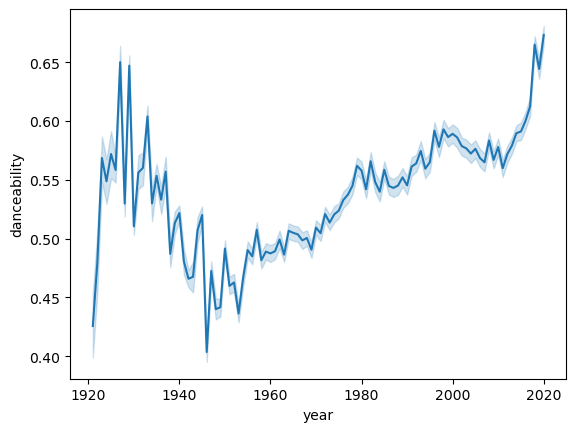

In [13]:
graph = sns.lineplot(cleandata, x= "year", y= "danceability")

In [14]:
interestdata.head(15)

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
5,1948-06-01,3.6
6,1948-07-01,3.6
7,1948-08-01,3.9
8,1948-09-01,3.8
9,1948-10-01,3.7


More cleaning: We checked and converted the dates to date time format for the data in the interest rate dataset. 

In [15]:
interestdata["DATE"].dtype

dtype('O')

In [16]:
interestdata['DATE']= pd.to_datetime(interestdata['DATE'], format='%Y-%m-%d', errors='coerce')
interestdata

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3
919,2024-08-01,4.2


Data manipulation: we average the interest rate and grouped by year to be the same scale as the spotify dataset. 

In [17]:
interestrate_year = duckdb.sql("SELECT year(DATE) AS Year, AVG(UNRATE) AS InterestRate FROM interestdata GROUP BY year(DATE)").df()
interestrate_year

,Year,InterestRate
0,1951,3.283333
1,1960,5.541667
2,1962,5.566667
3,1968,3.558333
4,1976,7.700000
...,...,...
72,1971,5.950000
73,1992,7.491667
74,1996,5.408333
75,2002,5.783333


We plotted a time series of the change in interest rate over the years. 

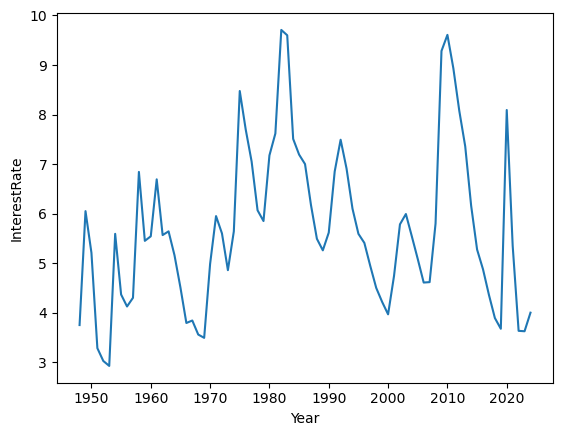

In [18]:
graph = sns.lineplot(interestrate_year, x= "Year", y= "InterestRate")

**After seeing them separately, we decided to see those two variables together.**
We did an inner join on danceability and interest rate, merging on year. As shown, there was a different scale of x (year) due to the inner join.  


In [19]:
dance_interest= duckdb.sql("SELECT interestrate_year.Year,\
        danceability, InterestRate FROM interestrate_year INNER JOIN \
        musicdata ON interestrate_year.Year = musicdata.year").df()
dance_interest

,Year,danceability,InterestRate
0,1948,0.486,3.750000
1,1948,0.310,3.750000
2,1948,0.619,3.750000
3,1948,0.307,3.750000
4,1948,0.091,3.750000
...,...,...,...
145469,2020,0.719,8.091667
145470,2020,0.514,8.091667
145471,2020,0.646,8.091667
145472,2020,0.512,8.091667


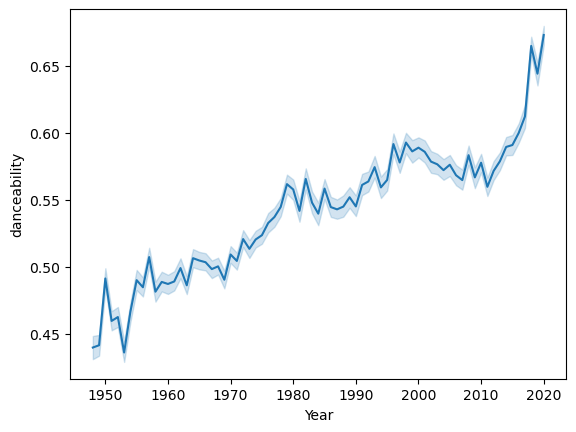

In [20]:
dangraph = sns.lineplot(dance_interest, x= "Year",y= "danceability")


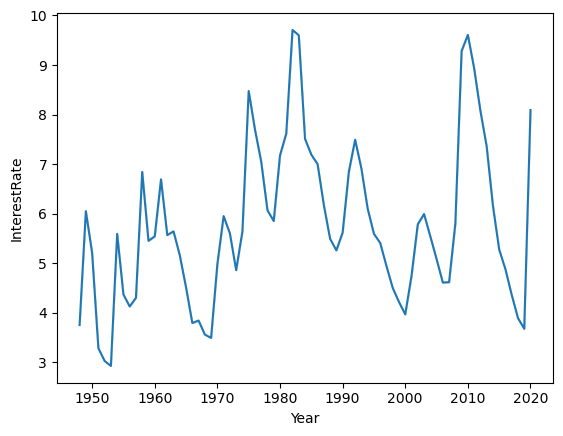

In [21]:
interestgraph = sns.lineplot(dance_interest, x= "Year", y= "InterestRate")

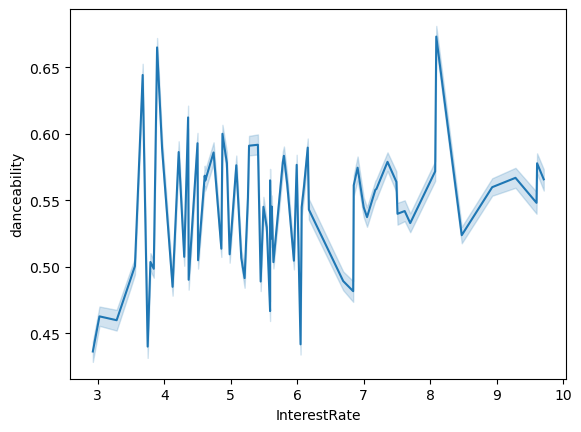

In [22]:
dan_interestgraph = sns.lineplot(dance_interest, x= "InterestRate", y= "danceability")

We ran the correlation, which is extremely weak. 
As shown the the graph, there is a a full range of danceability in virtually very interest rate level. 
We also looked at the regression coefficient, which was also very low.


In [23]:
dance_interest.corr()

,Year,danceability,InterestRate
Year,1.000000,0.260207,0.269437
danceability,0.260207,1.000000,0.069244
InterestRate,0.269437,0.069244,1.000000


We decided to plot a scatterplot to visualize the dataset we have to better understand the corr we got. We realized the datapoints that we have for each interest rate seems to have musics with a wide range of danceability score. This may justify why the corr value is low. 

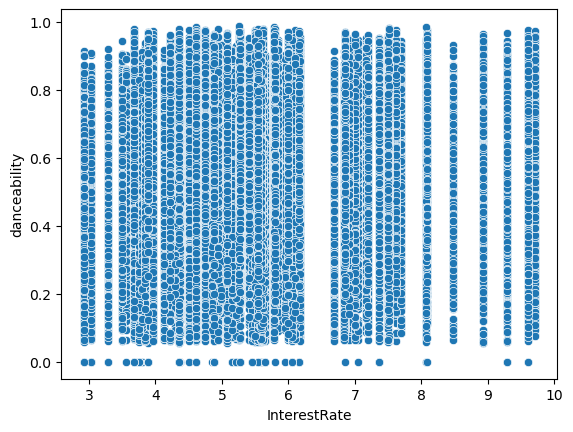

In [24]:
dance_interest_graph= sns.scatterplot(dance_interest, x="InterestRate", y="danceability")

In [25]:
X=dance_interest['InterestRate']
X= X.values.reshape(-1,1)
y=dance_interest['danceability']
lin_model = LinearRegression().fit(X,y)
print(lin_model.coef_)

[0.00750481]


Next, we decided to repeat the process for valence and interest rate. 
Again, the correlations were very weak but this time, it was stronger than danceability

In [26]:
valencedata= cleandata[['year','valence']]

In [27]:
valence_interest= duckdb.sql("SELECT interestrate_year.Year,\
        valence, InterestRate FROM interestrate_year INNER JOIN \
        valencedata ON interestrate_year.Year = valencedata.year").df()
valence_interest

,Year,valence,InterestRate
0,1971,0.540,5.95
1,1971,0.921,5.95
2,1971,0.432,5.95
3,1971,0.292,5.95
4,1971,0.342,5.95
...,...,...,...
145469,1971,0.631,5.95
145470,1971,0.635,5.95
145471,1971,0.740,5.95
145472,1971,0.954,5.95


In [28]:
valence_interest.corr()

,Year,valence,InterestRate
Year,1.000000,-0.021090,0.269437
valence,-0.021090,1.000000,0.052381
InterestRate,0.269437,0.052381,1.000000


**One again, we plotted a time series for average valence and average interest rate separately.**
Interestingly, we were able to visually observe some sort of pattern between valence and interest rate. For instance, 
in 1980 when there was a peak in interest rate, there also seemed to be a peak in valence. SImarly, when there was a low in interest 
rate right before 2020, there also seemed to be a corresponding low with valence. Although these observations do not indicate correlation,
we thought it was interesting to be able to see some sort of pattern as opposed to none with danceability and interest rate. 

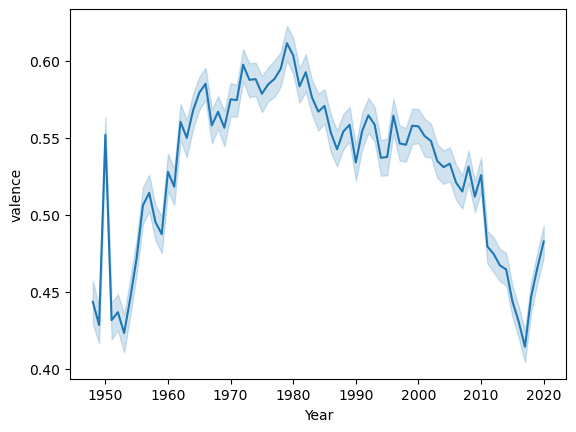

In [29]:
valencegraph = sns.lineplot(valence_interest, x= "Year", y= "valence")

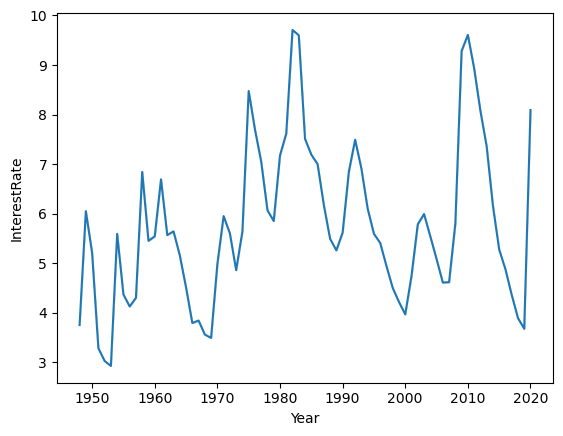

In [30]:
interestgraph = sns.lineplot(dance_interest, x= "Year", y= "InterestRate")

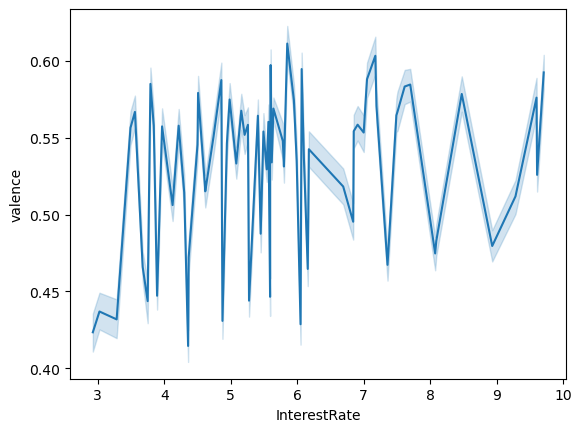

In [31]:
val_interestgraph = sns.lineplot(valence_interest, x= "InterestRate", y= "valence")

**
Data Cleaning: While looking through the different factors of calebelgut's dataset, we realized that a potential problem that caused the low correlation may be due to the fact that we did not account for each song's popularity, thus not accurately representing the music sentiment of the general population. Therefore we did further data cleaning and only considered songs above a certain popularity.**


The Popularity scale was from 0 to 100 and after looking at summary stats, we decided to filter to only songs with a rating greater or equal to 50.



In [32]:
musicdata['popularity'].unique()

array([  0,   1,   2,   3,   7,   6,   5,   4,   8,  14,  13,  11,  10,
        12,   9,  15,  19,  17,  18,  16,  20,  24,  21,  23,  22,  25,
        42,  28,  27,  37,  36,  35,  30,  26,  29,  44,  32,  33,  31,
        41,  46,  34,  45,  40,  38,  39,  54,  48,  58,  52,  47,  43,
        49,  51,  56,  55,  50,  57,  59,  66,  53,  61,  60,  62,  64,
        65,  69,  72,  63,  70,  68,  67,  71,  74,  75,  78,  81,  77,
        73,  80,  76,  79,  82,  83,  85,  84,  91,  92,  87,  86,  89,
        95,  93,  88,  90,  94,  99,  96, 100,  97])

In [33]:
musicdata['popularity'].mean()

31.55660971461194

In [34]:
musicdata['popularity'].mode()

0    0
Name: popularity, dtype: int64

In [35]:
musicdata['popularity'].median()

33.0

We then repeated the above analysis process with the spotify data songs (danceability and valence) filtered to only have the popular songs. 

In [36]:
number = duckdb.sql("SELECT COUNT(popularity), year, popularity FROM musicdata GROUP BY popularity,year HAVING popularity>=50").df()
number['popularity'].unique()
number

,count(popularity),year,popularity
0,21,1982,55
1,12,1985,59
2,11,1985,58
3,13,1986,57
4,22,1989,55
...,...,...,...
1877,1,2020,95
1878,9,2020,85
1879,15,1971,52
1880,34,1987,51


In [37]:
pop_dance_data=duckdb.sql("SELECT danceability, year, popularity FROM musicdata WHERE popularity>=50").df()
pop_dance_data

,danceability,year,popularity
0,0.596,1970,54
1,0.248,1973,58
2,0.523,1973,54
3,0.526,1973,52
4,0.594,1977,52
...,...,...,...
38476,0.875,2020,75
38477,0.719,2020,64
38478,0.514,2020,70
38479,0.646,2020,70


We first made a table that joins the dancebility of songs at specific years where the popularity is equal to or above 50. 

In [38]:
pop_dance_data=duckdb.sql("SELECT danceability, year, popularity FROM musicdata WHERE popularity>=50").df()
pop_dance_data

,danceability,year,popularity
0,0.596,1970,54
1,0.248,1973,58
2,0.523,1973,54
3,0.526,1973,52
4,0.594,1977,52
...,...,...,...
38476,0.875,2020,75
38477,0.719,2020,64
38478,0.514,2020,70
38479,0.646,2020,70


We then made a table that combined the interest rate and danceability at the specific years. 

In [39]:
pop_data_interest= duckdb.sql("SELECT interestrate_year.Year,\
        danceability, InterestRate FROM interestrate_year INNER JOIN \
        pop_dance_data ON interestrate_year.Year = pop_dance_data.year").df()
pop_data_interest

,Year,danceability,InterestRate
0,1970,0.596,4.983333
1,1977,0.594,7.050000
2,1979,0.442,5.850000
3,1980,0.556,7.175000
4,1981,0.613,7.616667
...,...,...,...
38459,1991,0.500,6.850000
38460,1991,0.716,6.850000
38461,1991,0.968,6.850000
38462,1991,0.629,6.850000


However, once again, we examined a very weak relationship. We made a scatterplot and once again, we observed a wide range 
of danceability over the range of interest rate. 

In [40]:
pop_data_interest.corr()

,Year,danceability,InterestRate
Year,1.000000,0.132852,-0.047336
danceability,0.132852,1.000000,-0.039838
InterestRate,-0.047336,-0.039838,1.000000


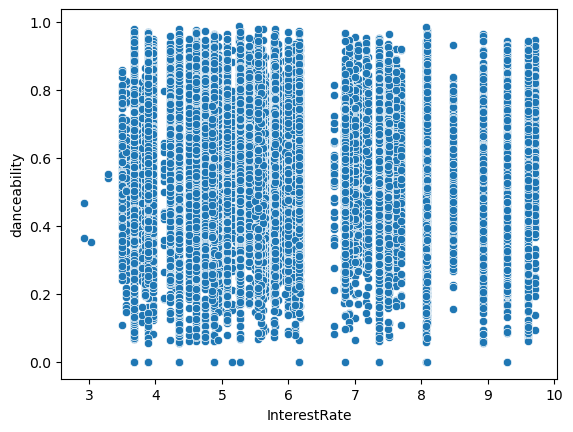

In [41]:
pop_data_interest_graph= sns.scatterplot(pop_data_interest, x="InterestRate", y="danceability")

We then suspected that a popularity of >=50 may not indicate that the songs were popular enough. Therefore, we further limited the popularity to >=90 to see if it would affect the correlation. 

In [42]:
most_pop_dance_data=duckdb.sql("SELECT danceability, year, popularity FROM musicdata WHERE popularity>=90").df()
most_pop_dance_data.head(15)

,danceability,year,popularity
0,0.680,2015,91
1,0.841,2016,92
2,0.784,2018,92
3,0.834,2018,92
4,0.896,2019,95
5,0.878,2019,93
6,0.621,2019,92
7,0.863,2019,95
8,0.787,2019,93
9,0.598,2019,91


In [43]:
most_pop_data_interest= duckdb.sql("SELECT interestrate_year.Year,\
        danceability, InterestRate FROM interestrate_year INNER JOIN \
        most_pop_dance_data ON interestrate_year.Year = most_pop_dance_data.year").df()
most_pop_data_interest.head(15)

,Year,danceability,InterestRate
0,2016,0.841,4.875000
1,2015,0.680,5.275000
2,2018,0.834,3.891667
3,2019,0.880,3.675000
4,2020,0.730,8.091667
5,2018,0.784,3.891667
6,2019,0.803,3.675000
7,2020,0.894,8.091667
8,2019,0.789,3.675000
9,2020,0.776,8.091667


We made a scatterplot of the interest rate and corresponded it with the data point danceability of the very popular songs (popularity >=90).
We noticed something very interesting: There was a wide range of data points at very low interest rate and very high interest rates, with 
limited data points for the interest rates in between. 

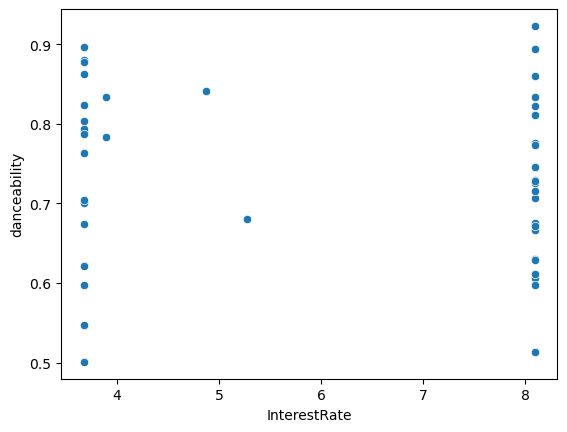

In [44]:
most_pop_data_interest_graph= sns.scatterplot(most_pop_data_interest, x="InterestRate", y="danceability")

In [45]:
most_pop_data_interest.corr()

,Year,danceability,InterestRate
Year,1.000000,-0.110148,0.601018
danceability,-0.110148,1.000000,-0.122449
InterestRate,0.601018,-0.122449,1.000000


When running with filtered valence, again, correlation matrix was very low but better than danceability. 

In [46]:
pop_valence_data=duckdb.sql("SELECT valence, year, popularity FROM musicdata WHERE popularity>=80").df()
pop_valence_data

,valence,year,popularity
0,0.677,2019,81
1,0.896,2019,80
2,0.486,2020,81
3,0.532,2020,81
4,0.639,2020,80
...,...,...,...
567,0.542,2020,82
568,0.708,2020,80
569,0.780,2020,81
570,0.536,2019,80


In [47]:
pop_valence_interest= duckdb.sql("SELECT interestrate_year.Year,\
        valence, InterestRate FROM interestrate_year INNER JOIN \
        pop_valence_data ON interestrate_year.Year = pop_valence_data.year").df()
pop_valence_interest

,Year,valence,InterestRate
0,2019,0.677,3.675000
1,2019,0.896,3.675000
2,2020,0.486,8.091667
3,2020,0.532,8.091667
4,2020,0.639,8.091667
...,...,...,...
567,2019,0.536,3.675000
568,2020,0.722,8.091667
569,1991,0.458,6.850000
570,1991,0.803,6.850000


Interestingly, when looking at the data, it seems when interest is extremely high, valence could seem to be also higher. 

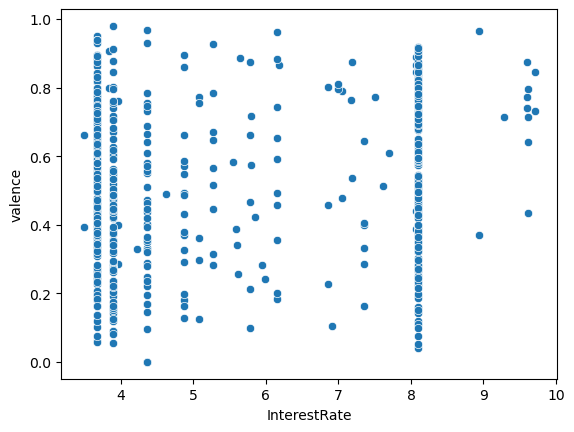

In [48]:
pop_valence_interest_graph= sns.scatterplot(pop_valence_interest, x="InterestRate", y="valence")

In [49]:
pop_valence_interest.corr()

,Year,valence,InterestRate
Year,1.000000,-0.098553,-0.079643
valence,-0.098553,1.000000,0.142910
InterestRate,-0.079643,0.142910,1.000000


When running with filtered valence, again, correlation matrix was very low but better than danceability. 

**We also thought it could be just due to the fact the interest rate and music sentiment could be a little too far fetched and tried it with the unemployment rate.** 


### Data Cleaning 
Since we are using SQL to mearge our data, we decide to rename the column name we space to avoid running into error. 

We decided to make a table that included information about the year, valence, and unemployment rate given that the 
popularity of the song is >=80. We wanted to see if unemployment plays a role in the valence of what songs become popular.

In [50]:
print(econdata.columns)
unemploymentdata= econdata[["Year","Unemployment Rate"]]
unemploymentdata.rename(columns={"Unemployment Rate": "Unemployment_Rate"}, inplace=True)

Index(['Year', 'Month', 'Day', 'Federal Funds Target Rate',
       'Federal Funds Upper Target', 'Federal Funds Lower Target',
       'Effective Federal Funds Rate', 'Real GDP (Percent Change)',
       'Unemployment Rate', 'Inflation Rate'],
      dtype='object')


/var/folders/hx/q_p8ztdn5zg4tw18gjwg262h0000gp/T/ipykernel_88647/229036560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unemploymentdata.rename(columns={"Unemployment Rate": "Unemployment_Rate"}, inplace=True)


In [51]:
valence_unemployment= duckdb.sql("SELECT unemploymentdata.Year,\
        valence, Unemployment_Rate, popularity FROM unemploymentdata INNER JOIN \
        musicdata ON unemploymentdata.Year = musicdata.year WHERE popularity>=80").df()
valence_unemployment

,Year,valence,Unemployment_Rate,popularity
0,2017,0.571,NaN,80
1,2017,0.195,NaN,80
2,2017,0.571,NaN,80
3,2017,0.195,NaN,80
4,2017,0.571,4.7,80
...,...,...,...,...
1637,1991,0.226,6.4,80
1638,1984,0.774,NaN,81
1639,1984,0.774,7.8,81
1640,1984,0.774,7.8,81


We checked if there were unemployment data for every year and dropped rows where there is no unemployment data. 

In [52]:
print("Number of unemploymentrate: ", len(valence_unemployment['Unemployment_Rate']))
print("Nan is present: ",\
      np.isnan(valence_unemployment['Unemployment_Rate']).any())

Number of unemploymentrate:  1642
Nan is present:  True


In [53]:
valence_unemployment=valence_unemployment.dropna()
valence_unemployment

,Year,valence,Unemployment_Rate,popularity
4,2017,0.571,4.7,80
5,2017,0.195,4.7,80
6,2017,0.571,4.8,80
7,2017,0.195,4.8,80
8,2002,0.100,6.0,83
...,...,...,...,...
1636,1991,0.803,6.4,81
1637,1991,0.226,6.4,80
1639,1984,0.774,7.8,81
1640,1984,0.774,7.8,81


We made a scatterplot. This time we were able to notice a trend. Interestingly, as the unemployment rate increase, the valence of music also 
seemed to shift up. 

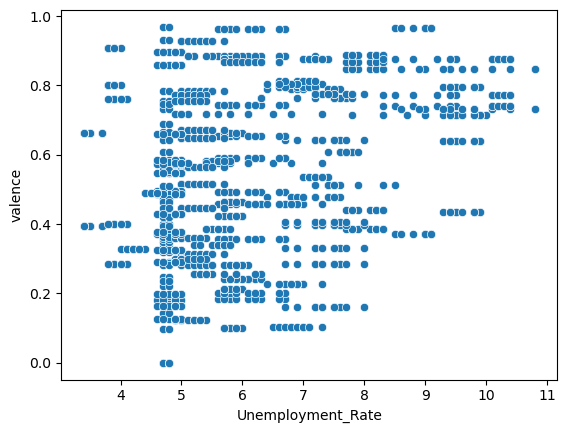

In [54]:
valence_unemployment_graph= sns.scatterplot(valence_unemployment, x="Unemployment_Rate", y="valence")

In [55]:
valence_unemployment.corr()

,Year,valence,Unemployment_Rate,popularity
Year,1.000000,-0.223153,-0.162089,0.167114
valence,-0.223153,1.000000,0.271042,-0.081581
Unemployment_Rate,-0.162089,0.271042,1.000000,-0.089201
popularity,0.167114,-0.081581,-0.089201,1.000000


In [56]:
X=valence_unemployment['Unemployment_Rate']
X= X.values.reshape(-1,1)
y=valence_unemployment['valence']
lin_model = LinearRegression().fit(X,y)
print(lin_model.coef_)

[0.04029805]


We then run a scatter plot to visualize data and regression on valence and employment which the coefficient turned out to be very low also (0.04). But the corr is higher compared to interest rate (0.27)

We decide to use another dataset to check if we can yield better corr. This dataset contains top 10000 songs from 1960 to 2023.

In [57]:
songdata.rename(columns={"Album Release Date": "Album_Release_Date"}, inplace=True)
songdata

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album_Release_Date,Album Image URL,...,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights
0,spotify:track:1XAZlnVtthcDZt2NI1Dtxo,Justified & Ancient - Stand by the Jams,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,spotify:album:4MC0ZjNtVP1nDD5lsLxFjc,Songs Collection,spotify:artist:6dYrdRlNZSKaVxYg5IrvCH,The KLF,1992-08-03,https://i.scdn.co/image/ab67616d0000b27355346b...,...,0.0480,0.015800,0.112000,0.4080,0.504,111.458,4.0,NaN,Jams Communications,"C 1992 Copyright Control, P 1992 Jams Communic..."
1,spotify:track:6a8GbQIlV8HBUW3c6Uk9PH,I Know You Want Me (Calle Ocho),spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,spotify:album:5xLAcbvbSAlRtPXnKkggXA,Pitbull Starring In Rebelution,spotify:artist:0TnOYISbd1XYRBk9myaseg,Pitbull,2009-10-23,https://i.scdn.co/image/ab67616d0000b27326d73a...,...,0.1490,0.014200,0.000021,0.2370,0.800,127.045,4.0,NaN,Mr.305/Polo Grounds Music/J Records,"P (P) 2009 RCA/JIVE Label Group, a unit of Son..."
2,spotify:track:70XtWbcVZcpaOddJftMcVi,From the Bottom of My Broken Heart,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,spotify:album:3WNxdumkSMGMJRhEgK80qx,...Baby One More Time (Digital Deluxe Version),spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears,1999-01-12,https://i.scdn.co/image/ab67616d0000b2738e4986...,...,0.0305,0.560000,0.000001,0.3380,0.706,74.981,4.0,NaN,Jive,P (P) 1999 Zomba Recording LLC
3,spotify:track:1NXUWyPJk5kO6DQJ5t7bDu,Apeman - 2014 Remastered Version,spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,spotify:album:6lL6HugNEN4Vlc8sj0Zcse,"Lola vs. Powerman and the Moneygoround, Pt. On...",spotify:artist:1SQRv42e4PjEYfPhS0Tk9E,The Kinks,2014-10-20,https://i.scdn.co/image/ab67616d0000b2731e7c53...,...,0.2590,0.568000,0.000051,0.0384,0.833,75.311,4.0,NaN,Sanctuary Records,"C © 2014 Sanctuary Records Group Ltd., a BMG C..."
4,spotify:track:72WZtWs6V7uu3aMgMmEkYe,You Can't Always Get What You Want,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,spotify:album:0c78nsgqX6VfniSNWIxwoD,Let It Bleed,spotify:artist:22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,1969-12-05,https://i.scdn.co/image/ab67616d0000b27373d927...,...,0.0687,0.675000,0.000073,0.2890,0.497,85.818,4.0,NaN,Universal Music Group,"C © 2002 ABKCO Music & Records Inc., P ℗ 2002 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,spotify:track:3kcKlOkQQEPVwxwljbGJ5p,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",spotify:album:2NIChqkijGw4r4Dqfmg0A3,Kernkraft 400 (A Better Day),"spotify:artist:0u6GtibW46tFX7koQ6uNJZ, spotify...","Topic, A7S",2022-06-17,https://i.scdn.co/image/ab67616d0000b273e1cafe...,...,0.0562,0.184000,0.000020,0.3090,0.400,125.975,4.0,NaN,Virgin,"C © 2022 Topic, under exclusive license to Uni..."
9995,spotify:track:5k9QrzJFDAp5cXVdzAi02f,Never Say Never - Radio Edit,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,spotify:album:2n506u3HKN3CaEDvAjv5Ct,Never Say Never,spotify:artist:1ScZSjoYAihNNm9qlhzDnL,Vandalism,2005-10-24,https://i.scdn.co/image/ab67616d0000b273b65ad4...,...,0.0340,0.000354,0.011200,0.3380,0.767,130.978,4.0,NaN,Vicious,"C 2005 Vicious, a division of Vicious Recordin..."
9996,spotify:track:5ydeCNaWDmFbu4zl0roPAH,Groovejet (If This Ain't Love) [feat. Sophie E...,"spotify:artist:4bmymFwDu9zLCiTRUmrewb, spotify...","Spiller, Sophie Ellis-Bextor",spotify:album:20Q3pGpYiyicF32x5L8ppH,Groovejet (If This Ain't Love) [feat. Sophie E...,spotify:artist:4bmymFwDu9zLCiTRUmrewb,Spiller,2000-08-14,https://i.scdn.co/image/ab67616d0000b27342781a...,...,0.0389,0.000132,0.088900,0.3610,0.626,123.037,4.0,NaN,Defected Records,"C © 2021 Defected Records Limited, P ℗ 2021 De..."
9997,spotify:track:0zKbDrEXKpnExhGQRe9dxt,Lay Low,spotify:artist:2o5jDhtHVPhrJdv3cEQ99Z,Tiësto,spotify:album:0EYKSXXTsON8ZA95BuCoXn,Lay Low,spotify:artist:2o5jDhtH

In [58]:
songdata['Album_Release_Date'] = pd.to_datetime(songdata['Album_Release_Date'], format='%Y-%m-%d', errors='coerce')

In [59]:
songdata = duckdb.sql("SELECT *, year(Album_Release_Date) AS year FROM songdata").df()

In [60]:
# no need to get popularity here in this dataset, b/c 
# this new data includes top 10000 songs
newvalence_unemployment= duckdb.sql("SELECT unemploymentdata.Year,\
        valence, Unemployment_Rate, popularity FROM unemploymentdata INNER JOIN \
        songdata ON unemploymentdata.Year = songdata.year").df()
newvalence_unemployment

,Year,Valence,Unemployment_Rate,Popularity
0,1992,0.504,7.4,0
1,2009,0.800,9.9,64
2,1999,0.706,4.0,56
3,2014,0.833,5.6,42
4,1969,0.497,3.5,0
...,...,...,...,...
106587,1984,0.200,8.0,0
106588,1984,0.635,8.0,75
106589,1984,0.795,8.0,83
106590,1984,0.298,8.0,0


In [61]:
# dropping na values
newvalence_unemployment=newvalence_unemployment.dropna()
newvalence_unemployment

,Year,Valence,Unemployment_Rate,Popularity
0,1992,0.504,7.4,0
1,2009,0.800,9.9,64
2,1999,0.706,4.0,56
3,2014,0.833,5.6,42
4,1969,0.497,3.5,0
...,...,...,...,...
106587,1984,0.200,8.0,0
106588,1984,0.635,8.0,75
106589,1984,0.795,8.0,83
106590,1984,0.298,8.0,0


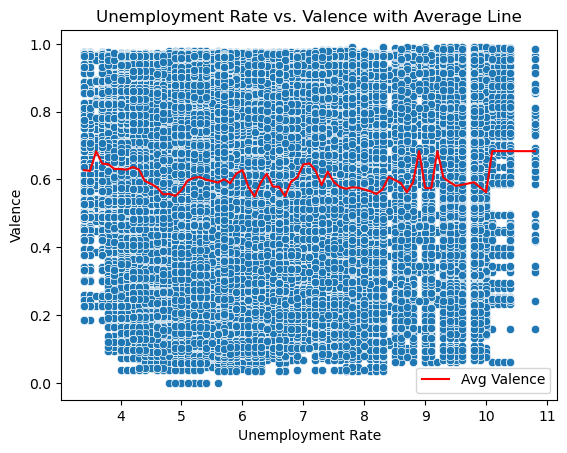

In [62]:
# getting the average valence grouped by unemployment rate
avg_valence_by_unemployment = newvalence_unemployment.groupby('Unemployment_Rate',\
    as_index=False)['Valence'].mean()

# graphing whether there is a correlation
sns.scatterplot(newvalence_unemployment,\
    x="Unemployment_Rate", y="Valence")

# adding lineplot to show average valence
sns.lineplot(data=avg_valence_by_unemployment,  
    x='Unemployment_Rate', y='Valence', color='red', label='Avg Valence')

# labeling
plt.xlabel('Unemployment Rate')
plt.ylabel('Valence')
plt.title('Unemployment Rate vs. Valence with Average Line')
plt.legend()

# show graph
plt.show()


Yet, the correlation matrix shows that there is a higher correlation between valence and unemployment rate, and popularity and unemployment rate.

In [63]:
newvalence_unemployment.corr()

,Year,Valence,Unemployment_Rate,Popularity
Year,1.000000,-0.175957,0.191215,-0.142985
Valence,-0.175957,1.000000,-0.010829,0.005984
Unemployment_Rate,0.191215,-0.010829,1.000000,-0.024349
Popularity,-0.142985,0.005984,-0.024349,1.000000


In [ ]:
merged_df.head()
print(merged_df['Year-Month'].dtype)

period[M]


In [ ]:
temp_df = duckdb.sql("""
                     SELECT * FROM merged_df ORDER BY Year-Month""").df()

NotImplementedException: Not implemented Error: Data type 'period[M]' not recognized

In [ ]:
merged_df.shape

(84651, 8)

### Exploratory Data Analysis

In [ ]:
numeric_columns = ['valence', 'danceability', 'tempo', 'UNRATE']
correlation_matrix = \
    merged_df[numeric_columns].corr()

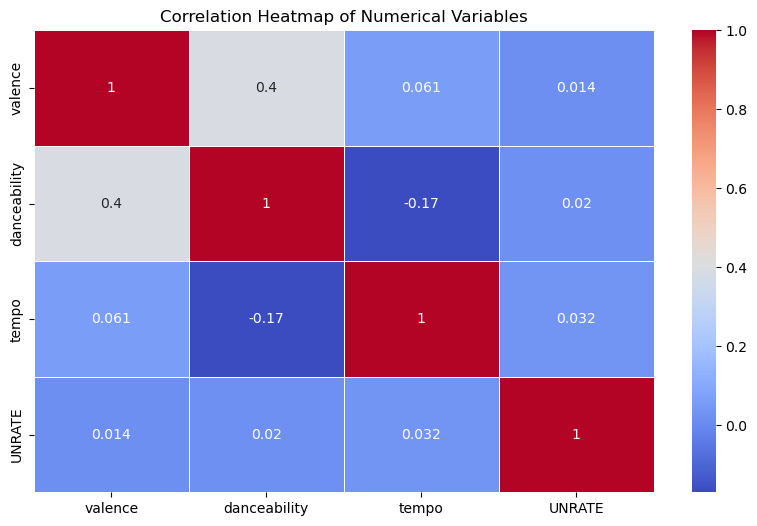

In [ ]:
# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

- describe findings

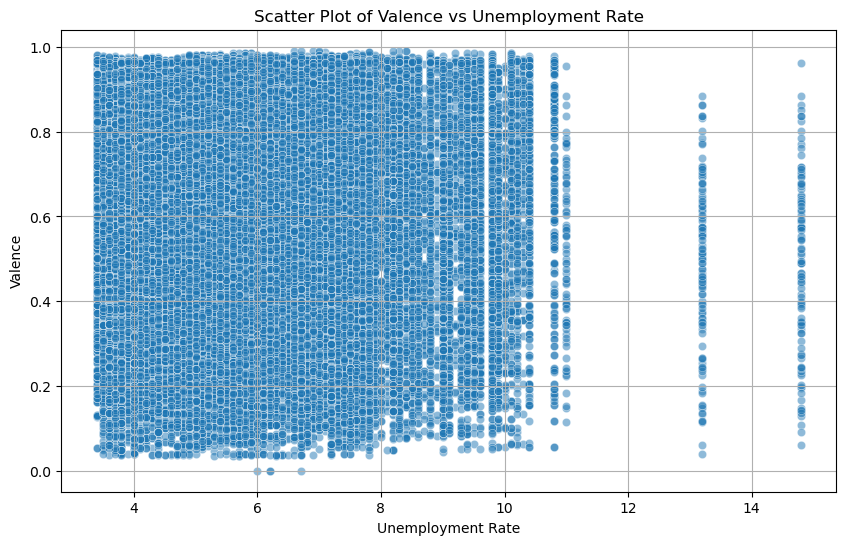

In [ ]:
# Plotting 'valence' vs 'UNRATE' to see if there is a relationship between mood of music and unemployment rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='UNRATE', y='valence', alpha=0.5)
plt.title('Scatter Plot of Valence vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Valence')
plt.grid(True)
plt.show()

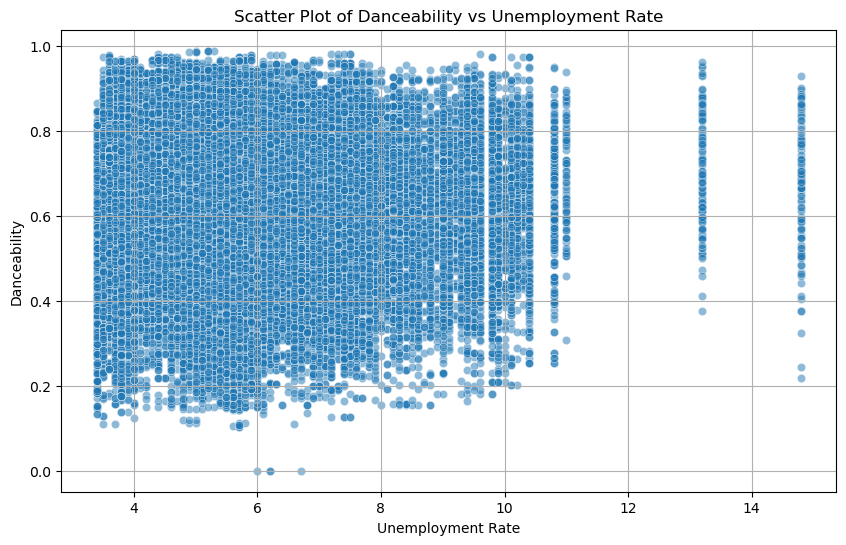

In [ ]:
# Scatter plot to visualize danceability and unemployment rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='UNRATE', y='danceability', alpha=0.5)
plt.title('Scatter Plot of Danceability vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Danceability')
plt.grid(True)
plt.show()

In [ ]:
# since data looks disorganized, I'm trying to average these plots and see if there is any relationships
unemployment_grouped = merged_df.groupby('UNRATE').agg({'valence': 'mean', 'danceability': 'mean'}).reset_index()

In [ ]:
valence_unrate_corr = unemployment_grouped['valence'].corr(unemployment_grouped['UNRATE'])
danceability_unrate_corr = unemployment_grouped['danceability'].corr(unemployment_grouped['UNRATE'])


In [ ]:
# running correlation
print(valence_unrate_corr)
print(danceability_unrate_corr)

-0.13003287788810883
0.36605990244634445


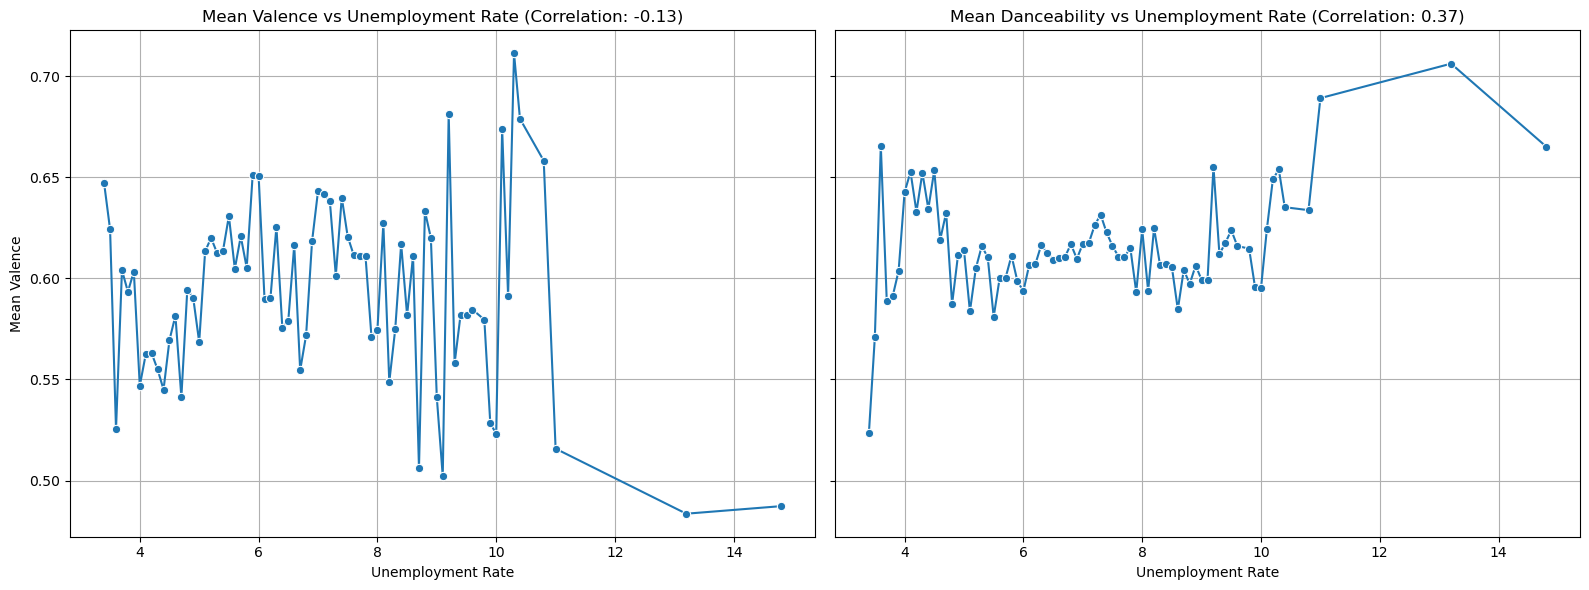

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Mean Valence vs Unemployment Rate
sns.lineplot(ax=axes[0], data=unemployment_grouped, x='UNRATE', y='valence', marker='o')
axes[0].set_title(f'Mean Valence vs Unemployment Rate (Correlation: {valence_unrate_corr:.2f})')
axes[0].set_xlabel('Unemployment Rate')
axes[0].set_ylabel('Mean Valence')
axes[0].grid(True)

# Mean Danceability vs Unemployment Rate
sns.lineplot(ax=axes[1], data=unemployment_grouped, x='UNRATE', y='danceability', marker='o')
axes[1].set_title(f'Mean Danceability vs Unemployment Rate (Correlation: {danceability_unrate_corr:.2f})')
axes[1].set_xlabel('Unemployment Rate')
axes[1].grid(True)

plt.tight_layout()
plt.show()

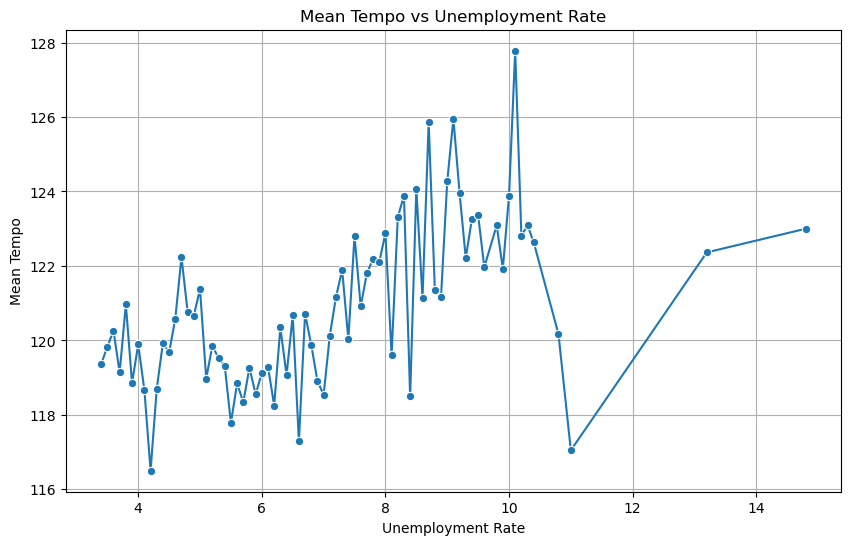

In [ ]:
# for tempo
tempo_unemployment_grouped = merged_df.groupby('UNRATE').agg({'tempo': 'mean'}).reset_index()

# Plot mean tempo vs unemployment rate
plt.figure(figsize=(10, 6))
sns.lineplot(data=tempo_unemployment_grouped, x='UNRATE', y='tempo', marker='o')
plt.title('Mean Tempo vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Mean Tempo')
plt.grid(True)
plt.show()

In [ ]:
# Analyze unemployment's effect on danceability and valence by genre
# I used chatgpt for this one
# Explode 'spotify_genre' into multiple rows for genres associated with each track
merged_df_exploded = merged_df.explode('spotify_genre')
merged_df_exploded['spotify_genre'] = merged_df_exploded['spotify_genre'].str.strip("[]'").str.lower()

# Group by 'UNRATE' and 'spotify_genre' and calculate mean 'danceability' and 'valence'
genre_grouped = merged_df_exploded.groupby(['UNRATE', 'spotify_genre']).agg({'danceability': 'mean', 'valence': 'mean'}).reset_index()

In [ ]:
# Count the frequency of each genre to identify the most common ones
genre_counts = merged_df_exploded['spotify_genre'].value_counts()

# Select the top 10 most common genres for visualization
top_genres = genre_counts.head(10).index

# Filter the dataset to only include the top genres
filtered_genre_grouped = genre_grouped[genre_grouped['spotify_genre'].isin(top_genres)]

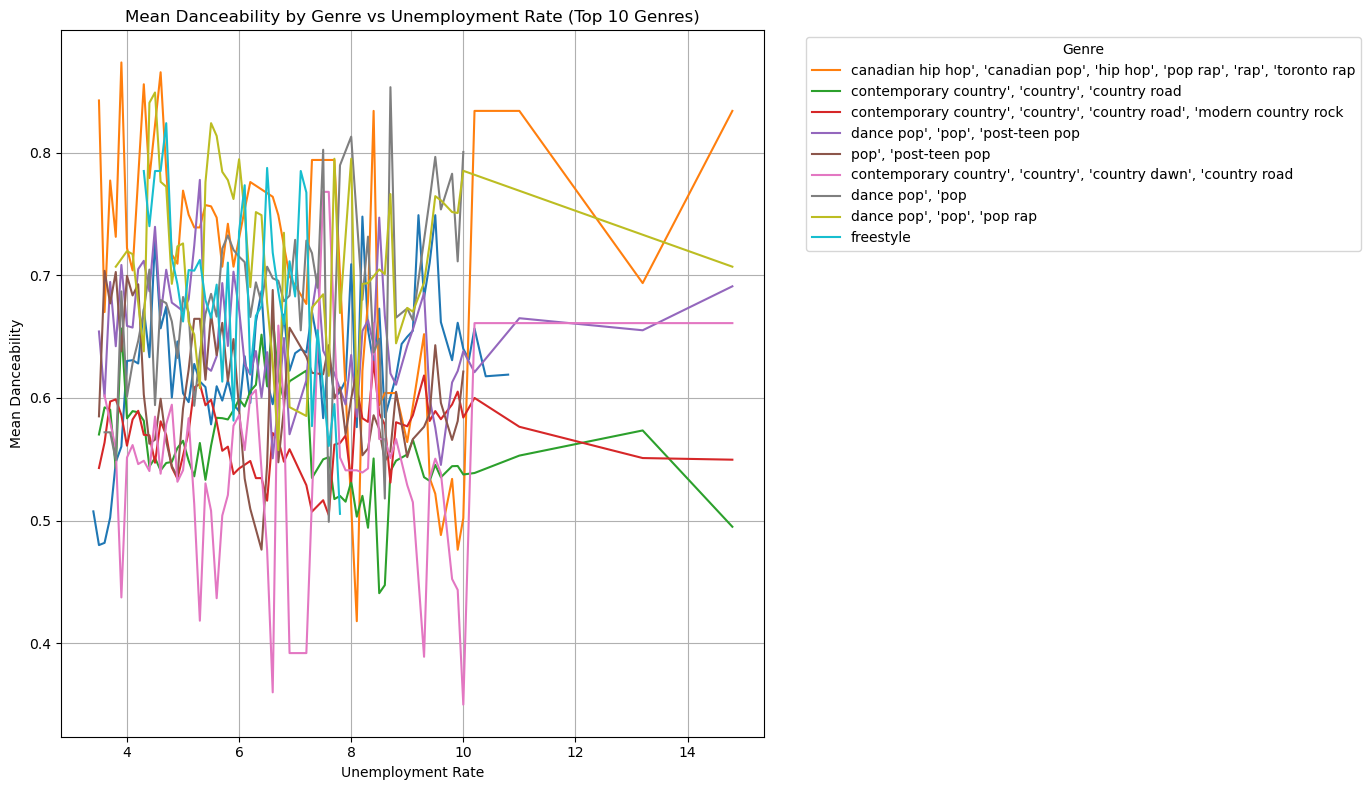

In [ ]:
# Plot danceability by genre vs unemployment rate (for top genres)
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_genre_grouped, x='UNRATE', y='danceability', hue='spotify_genre', palette='tab10')
plt.title('Mean Danceability by Genre vs Unemployment Rate (Top 10 Genres)')
plt.xlabel('Unemployment Rate')
plt.ylabel('Mean Danceability')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

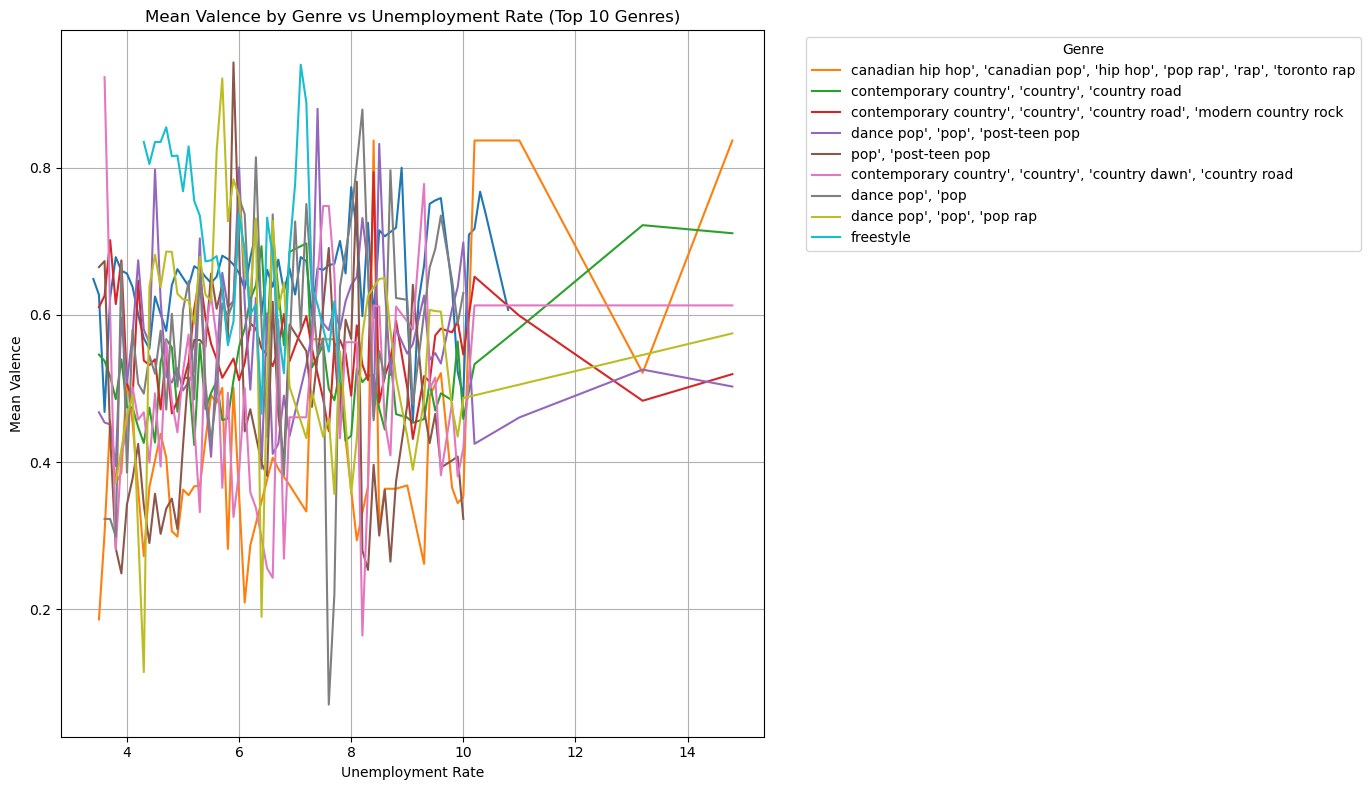

In [ ]:
# Plot valence by genre vs unemployment rate (for top genres)
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_genre_grouped, x='UNRATE', y='valence', hue='spotify_genre', palette='tab10')
plt.title('Mean Valence by Genre vs Unemployment Rate (Top 10 Genres)')
plt.xlabel('Unemployment Rate')
plt.ylabel('Mean Valence')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Data Limitations
The spotify data set and 2nd song data set that we have represent the popularity globally. Couldn't find a dataset based on only the US population. 


#### Questions
- Given the low correlation and linear regression coefficient, is there a better model for us to train the data?
- How can we transform our model to better fit the data?
- How to cite resources?